In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import pytorch_utils
import pytorch_models
#reload these libraries because I change them often-ish
imp.reload(pytorch_utils)
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

db_name="sample_swap_free_final"
drum_df=pd.concat([miru.audioFrames(db_name="radar",loadCache=True),miru.audioFrames(db_name="sample_swap",loadCache=True)])
noise_df=miru.audioFrames(db_name="noise",loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_df=noise_df[0:1000]
len(drum_df),len(noise_df)

loading data base from ./drum_dbs/radar ./drum_dbs/radar.dill
loading data base from ./drum_dbs/sample_swap ./drum_dbs/sample_swap.dill
loading data base from ./drum_dbs/noise ./drum_dbs/noise.dill


(4886, 1000)

In [2]:
dLabels, dUniques=pd.factorize(drum_df["label"].tolist())
ndLabels, ndUniques=pd.factorize(noise_df["label"].tolist())

drum_df.loc[:,"label_num"]=dLabels
noise_df.loc[:,"label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])

y=drum_df.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])

label
clap                401
electronic_hits     235
hat                1275
kick               1334
noise               168
rim                  82
shake               116
snare              1035
tom                 167
voc                  73
Name: path, dtype: int64


In [3]:
#define a dataset
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label"]!="synth_noise","label_num"]=0 
            self.audio_frame.loc[self.audio_frame["label"]=="synth_noise","label_num"]=1 
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label"]!="synth_noise"]
        if self.task=="keep_all":
            pass



all_frames=pd.concat([drum_df,noise_df],sort=True).reset_index(drop=True)



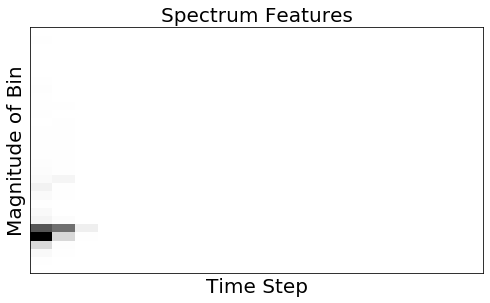

In [4]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20,amp_to_power=False):
        self.amp_to_power=amp_to_power
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=10)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        if self.amp_to_power:
            s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq
        return (freq.detach(),sample["drum_type"])
    
#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))


#make a data point real quick
ds=audioDataset(pd.concat([all_frames],sort=False),"./",task="dvn",)
sample = ds[np.random.randint(len(drum_df))]
sample={"signal":sample["signal"],"label":sample["label"],"path":sample["path"],"drum_type":sample["drum_type"]}

tfList=[specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()

    ft=transformed_sample[0][0]
    sf=ft.detach().numpy()
    ft=ft.detach().numpy()
    plt.title("Spectrum Features",fontsize=20)
    librosa.display.specshow(sf,cmap='gray_r',)
    plt.xlabel("Time Step",fontsize=20)
    plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
# print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


In [5]:

#defining data loaders
FREQ_BINS = 30
TIME_STEPS = 30            
pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
train = all_frames.sample(frac=0.70,random_state=420) 
test_and_valid = all_frames.drop(train.index)
test = test_and_valid.sample(frac=0.70,random_state=420) 
valid = test_and_valid.drop(test.index)

spec_data_train = audioDataset(train,".","dvd", transform=pt)
spec_data_test = audioDataset(test,".",task="dvd", transform=pt)
spec_data_valid = audioDataset(valid,".",task="dvd", transform=pt)

spec_data_valid[0][1]

'hat'

In [6]:
# x=next(iter(train_loader))
# print(len(train_dataset),x[0].shape)

# x=next(iter(test_loader))
# print(len(test_dataset),x[0].shape)

# x=next(iter(valid_loader))
# print(len(valid_dataset),x[0].shape)


# replicating prototypical networks

In [19]:
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels


def pairwise_distances_logits(a, b):
    n = a.shape[0]
    m = b.shape[0]
    logits = -((a.unsqueeze(1).expand(n, m, -1) -
                b.unsqueeze(0).expand(n, m, -1))**2).sum(dim=2)
    return logits


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


class Convnet(nn.Module):

    def __init__(self, x_dim=1, hid_dim=32, z_dim=64):
        super().__init__()
        self.encoder = l2l.vision.models.ConvBase(output_size=z_dim,
                                                  hidden=hid_dim,
                                                  channels=x_dim)
        self.out_channels = 1600

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)


def fast_adapt(model, batch, ways, shot, query_num, metric=None, device=None):
    if metric is None:
        metric = pairwise_distances_logits
    if device is None:
        device = model.device()
    data, labels = batch
    data = data.to(device)
    labels = labels.to(device)
    n_items = shot * ways

    # Sort data samples by labels
    # TODO: Can this be replaced by ConsecutiveLabels ?
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    # Compute support and query embeddings
    embeddings = model(data)
    support_indices = np.zeros(data.size(0), dtype=bool)
    selection = np.arange(ways) * (shot + query_num)
    for offset in range(shot):
        support_indices[selection + offset] = True
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support = embeddings[support_indices]
    support = support.reshape(ways, shot, -1).mean(dim=1)
    query = embeddings[query_indices]
    print(query)
    print(labels)
    labels = labels[query_indices].long()

    logits = pairwise_distances_logits(query, support)
    loss = F.cross_entropy(logits, labels)
    acc = accuracy(logits, labels)
    return loss, acc


In [33]:
max_epoch = 10

shot = 5
train_way = 10
train_query = 1

test_shot = 5
test_way = 10
test_query = 1



device = torch.device('cpu')
if torch.cuda.device_count():
    print("gpu available")
    torch.cuda.manual_seed(43)
    device = torch.device('cuda')

model = Convnet()
model.to(device)

# path_data = '~/data'
# train_dataset = l2l.vision.datasets.MiniImagenet(
#     root=path_data, mode='train')
# valid_dataset = l2l.vision.datasets.MiniImagenet(
#     root=path_data, mode='validation')
# test_dataset = l2l.vision.datasets.MiniImagenet(
#     root=path_data, mode='test')
train_dataset = audioDataset(train,".","keep_all", transform=pt)
test_dataset  = audioDataset(test,".",task="keep_all", transform=pt)
valid_dataset  = audioDataset(test,".",task="keep_all", transform=pt)



train_dataset = l2l.data.MetaDataset(train_dataset)
train_transforms = [
    NWays(train_dataset, train_way),
    KShots(train_dataset, train_query +  shot),
    LoadData(train_dataset),
    RemapLabels(train_dataset),
]
train_tasks = l2l.data.TaskDataset(train_dataset, task_transforms=train_transforms,num_tasks=200)
train_loader = DataLoader(train_tasks, pin_memory=True, shuffle=True)

valid_dataset = l2l.data.MetaDataset(valid_dataset)
valid_transforms = [
    NWays(valid_dataset,  test_way),
    KShots(valid_dataset,  test_query +  test_shot),
    LoadData(valid_dataset),
    RemapLabels(valid_dataset),
]
valid_tasks = l2l.data.TaskDataset(valid_dataset,
                                   task_transforms=valid_transforms,
                                   num_tasks=50)
valid_loader = DataLoader(valid_tasks, pin_memory=True, shuffle=True)

test_dataset = l2l.data.MetaDataset(test_dataset)
test_transforms = [
    NWays(test_dataset,  test_way),
    KShots(test_dataset,  test_query +  test_shot),
    LoadData(test_dataset),
    RemapLabels(test_dataset),
]
test_tasks = l2l.data.TaskDataset(test_dataset,
                                  task_transforms=test_transforms,
                                  num_tasks=100)
test_loader = DataLoader(test_tasks, pin_memory=True, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.5)


gpu available


In [35]:
for epoch in range(1,  max_epoch + 1):
    model.train()

    loss_ctr = 0
    n_loss = 0
    n_acc = 0

    for i in range(100):
        batch = next(iter(train_loader))

        loss, acc = fast_adapt(model,
                               batch,
                                train_way,
                                shot,
                                train_query,
                               metric=pairwise_distances_logits,
                               device=device)

        loss_ctr += 1
        n_loss += loss.item()
        n_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()

    print('epoch {}, train, loss={:.4f} acc={:.4f}'.format(
        epoch, n_loss/loss_ctr, n_acc/loss_ctr))

    model.eval()

    loss_ctr = 0
    n_loss = 0
    n_acc = 0
    for i, batch in enumerate(valid_loader):
        loss, acc = fast_adapt(model,
                               batch,
                                test_way,
                                test_shot,
                                test_query,
                               metric=pairwise_distances_logits,
                               device=device)

        loss_ctr += 1
        n_loss += loss.item()
        n_acc += acc

    print('epoch {}, val, loss={:.4f} acc={:.4f}'.format(
        epoch, n_loss/loss_ctr, n_acc/loss_ctr))

loss_ctr = 0
n_acc = 0

for i, batch in enumerate(test_loader, 1):
    loss, acc = fast_adapt(model,
                           batch,
                            test_way,
                            test_shot,
                            test_query,
                           metric=pairwise_distances_logits,
                           device=device)
    loss_ctr += 1
    n_acc += acc
    print('batch {}: {:.2f}({:.2f})'.format(
        i, n_acc/loss_ctr * 100, acc * 100))

epoch 1, train, loss=0.8778 acc=0.7020
epoch 1, val, loss=1.2874 acc=0.5840
epoch 2, train, loss=0.7345 acc=0.7470
epoch 2, val, loss=1.2710 acc=0.6240
epoch 3, train, loss=0.6041 acc=0.7840
epoch 3, val, loss=1.2297 acc=0.6120
epoch 4, train, loss=0.6502 acc=0.7840
epoch 4, val, loss=1.3862 acc=0.5860
epoch 5, train, loss=0.5750 acc=0.8080
epoch 5, val, loss=1.3416 acc=0.6080
epoch 6, train, loss=0.4625 acc=0.8350
epoch 6, val, loss=1.4514 acc=0.6140
epoch 7, train, loss=0.4952 acc=0.8420
epoch 7, val, loss=1.2800 acc=0.6060
epoch 8, train, loss=0.4487 acc=0.8570
epoch 8, val, loss=1.5088 acc=0.6000
epoch 9, train, loss=0.3592 acc=0.8860
epoch 9, val, loss=1.3270 acc=0.5960
epoch 10, train, loss=0.3001 acc=0.9070
epoch 10, val, loss=1.6608 acc=0.6080
batch 1: 70.00(70.00)
batch 2: 70.00(70.00)
batch 3: 63.33(50.00)
batch 4: 65.00(70.00)
batch 5: 66.00(70.00)
batch 6: 65.00(60.00)
batch 7: 62.86(50.00)
batch 8: 61.25(50.00)
batch 9: 62.22(70.00)
batch 10: 62.00(60.00)
batch 11: 63.64(8

In [ ]:
torch.save({
            'epoch': 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)